## Figure 3
Distribution of parameter values from MCMC calibration.
Each row shows a different model (OV, SL, RU). Each column shows a different parameter (sigma_org, delta_min / A0, C0, m_sigma).
In the title of each subplot is the best fit and 95% CI for each parameter value.

In [1]:
import numpy as np
import os
from matplotlib import pylab

from PySDM.physics import si

from PySDM_examples.Singer_Ward.kappa_mcmc import get_model, param_transform
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.mcmc_plots import plot_ovf_kappa_fit

filename = "bcary_dark.csv"

# model = "CompressedFilmOvadnevaite"
# N = 1000
model = "SzyszkowskiLangmuir"
N = 1500
# model = "CompressedFilmRuehl"
# N = 5000

######
# open data file
######
ds = np.loadtxt("data/" + filename, skiprows=1, delimiter=",")
if filename == "bcary_dark.csv":
    ds = np.delete(ds, [26, 65], axis=0)  # remove outliers
r_dry = ds[:, 0] / 2 * 1e-9
ovf = np.minimum(ds[:, 1], 0.99)
d_ovf = ds[:, 2]
kappa_eff = ds[:, 3]
d_kappa_eff = ds[:, 4]
T = 300 * si.K

datay = kappa_eff
errory = d_kappa_eff

from PySDM.physics import constants_defaults
CONSTANTS = {
    'Mv': constants_defaults.Mv,
    'rho_w': constants_defaults.rho_w
}
WATER_MOLAR_VOLUME = CONSTANTS['Mv'] / CONSTANTS['rho_w']
aerosol_list = [AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=ovfi) for ovfi in ovf]
args = [T, r_dry, ovf, aerosol_list, model]

modelname = model.split("CompressedFilm")[-1]
aerosolname = aerosol_list[0].__class__.__name__.split("Aerosol")[-1]
outputfile = "mcmc_output/" + aerosolname + "_" + modelname + "_chain" + str(N) + ".csv"
param_chain = np.loadtxt(outputfile, delimiter=",").T

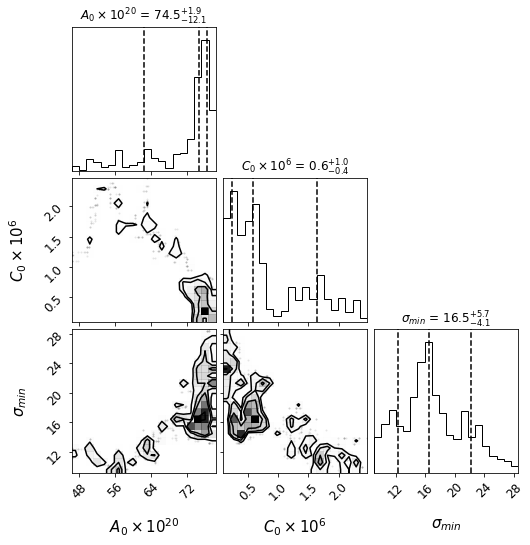

In [2]:
from corner import corner
from matplotlib import pylab
from PySDM_examples.Singer_Ward.kappa_mcmc import get_model, param_transform

def model_options(model):
    if model == "CompressedFilmOvadnevaite":
        labels = ["$\sigma_{org}$", "$\delta_{min}$"]
        scaling = [1, 1]
    elif model == "SzyszkowskiLangmuir":
        labels = ["$A_0 \\times 10^{20}$", "$C_0 \\times 10^{6}$", "$\sigma_{min}$"]
        scaling = [1e20, 1e6, 1]
    elif model == "CompressedFilmRuehl":
        labels = [
            "$A_0 \\times 10^{20}$",
            "$C_0 \\times 10^{6}$",
            "$\sigma_{min}$",
            "$m_{\sigma} \\times 10^{-16}$",
        ]
        scaling = [1e20, 1e6, 1, 1e-16]
    else:
        raise AssertionError()
    return labels, scaling

_, _, _, c, model = args
data = param_transform(param_chain, model).T
data = data[100:, :]

labels, scaling = model_options(model)

pylab.rcParams.update({"font.size": 12})
_ = corner(
    data * scaling,
    labels=labels,
    label_kwargs={"fontsize": 15},
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".1f",
    title_kwargs={"fontsize": 12},
)

modelname = model.split("CompressedFilm")[-1]
aerosolname = c[0].__class__.__name__.split("Aerosol")[-1]
pylab.savefig(
    "mcmc_output/" + aerosolname + "_" + modelname + "_corner.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)
pylab.show()